Given a date, displays the injected gas meter volume and its respective percentage the gas valve is open

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

The dates in this file are from 2024-10-31 to 2024-11-07.


C:\Users\sadha\AppData\Local\Temp\ipykernel_20108\1640955997.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day['Inj Gas Valve Percent Open'] = day['Inj Gas Valve Percent Open'].interpolate(method='linear')
C:\Users\sadha\AppData\Local\Temp\ipykernel_20108\1640955997.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day['Inj Gas Meter Volume Instantaneous'] = day['Inj Gas Meter Volume Instantaneous'].interpolate(method='linear')


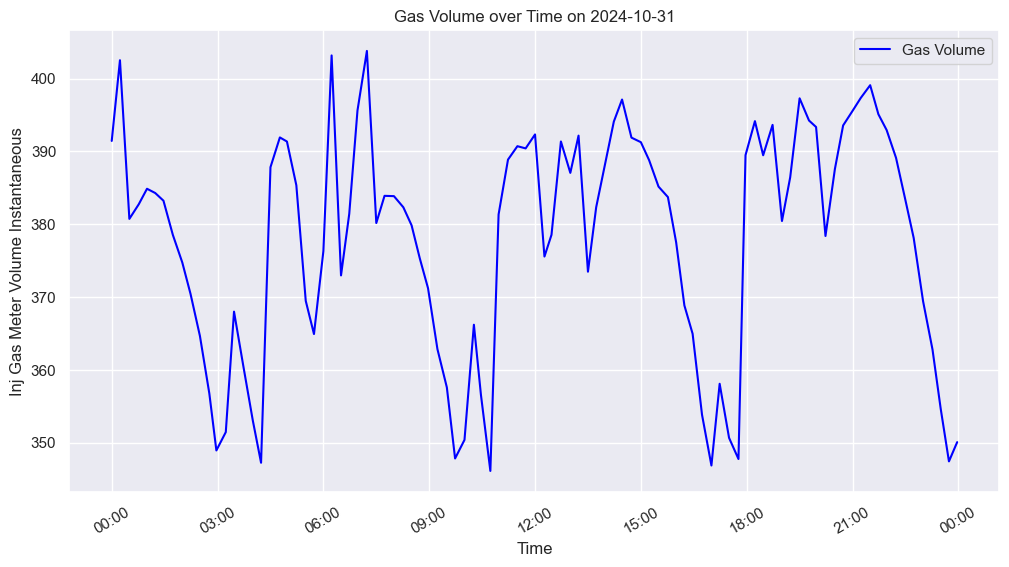

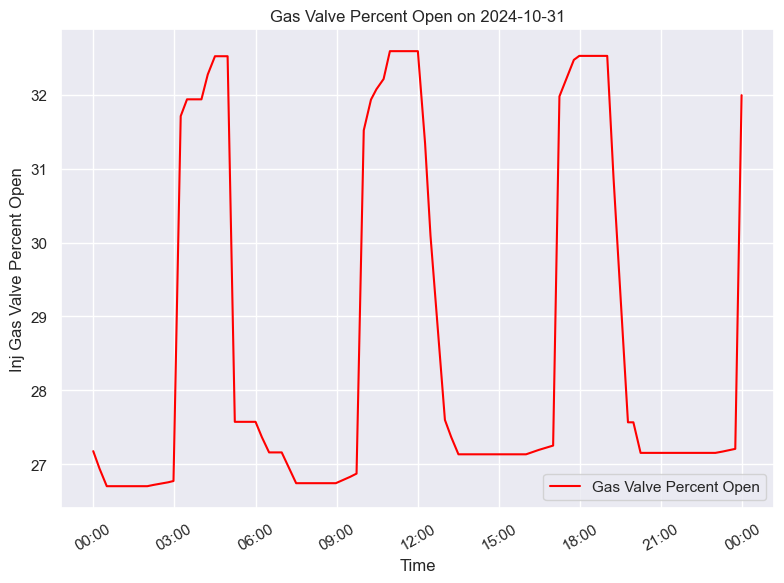

In [3]:
name = input("what's the name of your file? ")
data = pd.read_csv(name) # reads csv file

# convert the 'Time' column to datetime format
data['Time'] = pd.to_datetime(data['Time'], format='%m/%d/%Y %I:%M:%S %p')

start = data['Time'].iloc[0].date()
end = data['Time'].iloc[-1].date() 
print(f"The dates in this file are from {start} to {end}.")

# filter over a single day: YYYY-MM-DD testing - 2024-10-31
input_date = input("Which day would you like to inspect? Type in YYYY-MM-DD.")
day = data[data['Time'].dt.date == pd.to_datetime(input_date).date()]

day['Inj Gas Valve Percent Open'] = day['Inj Gas Valve Percent Open'].interpolate(method='linear')
day['Inj Gas Meter Volume Instantaneous'] = day['Inj Gas Meter Volume Instantaneous'].interpolate(method='linear')
# print(day[['Time', 'Inj Gas Valve Percent Open', 'Inj Gas Meter Volume Instantaneous']])

sns.set_theme()

# plotting
fig, ax1 = plt.subplots(figsize=(12, 6))
sns.lineplot(x='Time', y='Inj Gas Meter Volume Instantaneous', data=day, ax=ax1, color='blue', label='Gas Volume')

# only time
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))

ax1.set_xlabel('Time')
ax1.set_ylabel('Inj Gas Meter Volume Instantaneous')
plt.title(f"Gas Volume over Time on {input_date}")
plt.xticks(rotation=30)

fig_percent, ax2 = plt.subplots(figsize=(8,6))
sns.lineplot(x='Time', y='Inj Gas Valve Percent Open', data=day, ax=ax2, color='red', label='Gas Valve Percent Open')
ax2.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
ax2.set_xlabel('Time')
ax2.set_ylabel('Inj Gas Valve Percent Open')
plt.title(f"Gas Valve Percent Open on {input_date}")
plt.xticks(rotation=30)
plt.tight_layout()

plt.show()

logistic regression to predict whether hydrate will form or not.

In [7]:
name = input("what's the name of your file? ")
data = pd.read_csv(name) # reads csv file

# time to datetime
data['Time'] = pd.to_datetime(data['Time'])


# interpolation for missing percentage values
data['Inj Gas Valve Percent Open'] = data['Inj Gas Valve Percent Open'].interpolate(method='linear')
data['Inj Gas Meter Volume Instantaneous'] = data['Inj Gas Meter Volume Instantaneous'].interpolate(method='linear')

setpoint_value = data['Inj Gas Meter Volume Setpoint'].dropna().iloc[0]
print(setpoint_value)
data['Inj Gas Meter Volume Setpoint'] = setpoint_value

# error between the instantaneous gas meter volumes and setpoint
data['Error'] = data['Inj Gas Meter Volume Instantaneous'] - data['Inj Gas Meter Volume Setpoint']
data.head()


# sample thresholds to determine hydrate formation
high_volume_threshold = data['Inj Gas Meter Volume Instantaneous'].quantile(0.75)  # top 25% as "high volume"
low_percent_threshold = data['Inj Gas Valve Percent Open'].quantile(0.25)  # bottom 25% as "low percent"


# 'Hydrate_Formed' based on these conditions
data['Hydrate_Formed'] = (
    (data['Inj Gas Meter Volume Instantaneous'] > high_volume_threshold) &
    (data['Inj Gas Valve Percent Open'] < low_percent_threshold) &
    (data['Error'] > 0)
)
data['Hydrate_Formed'] = data['Hydrate_Formed'].astype(int)
data.head(50)

X = data[['Inj Gas Valve Percent Open', 'Error', 'Inj Gas Meter Volume Instantaneous']]
y = data['Hydrate_Formed']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = LogisticRegression()
model.fit(X_train, y_train)
print(X_train, y_train)
model.predict(X_test)

y_pred = model.predict(X_test)

375.0
     Inj Gas Valve Percent Open     Error  Inj Gas Meter Volume Instantaneous
430                    32.67054  -7.73175                           367.26825
249                    27.03376 -29.39175                           345.60825
220                    32.41834 -24.58770                           350.41230
18                     32.52163  12.82695                           387.82695
244                    26.81901  -6.00015                           368.99985
..                          ...       ...                                 ...
71                     32.47241 -27.26070                           347.73930
106                    27.44286   7.07295                           382.07295
270                    27.45996   9.57390                           384.57390
435                    34.06752  -8.61315                           366.38685
102                    32.29950 -26.38980                           348.61020

[541 rows x 3 columns] 430    0
249    0
220    0
18     

C:\Users\sadha\AppData\Local\Temp\ipykernel_20108\1102576945.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Time'] = pd.to_datetime(data['Time'])


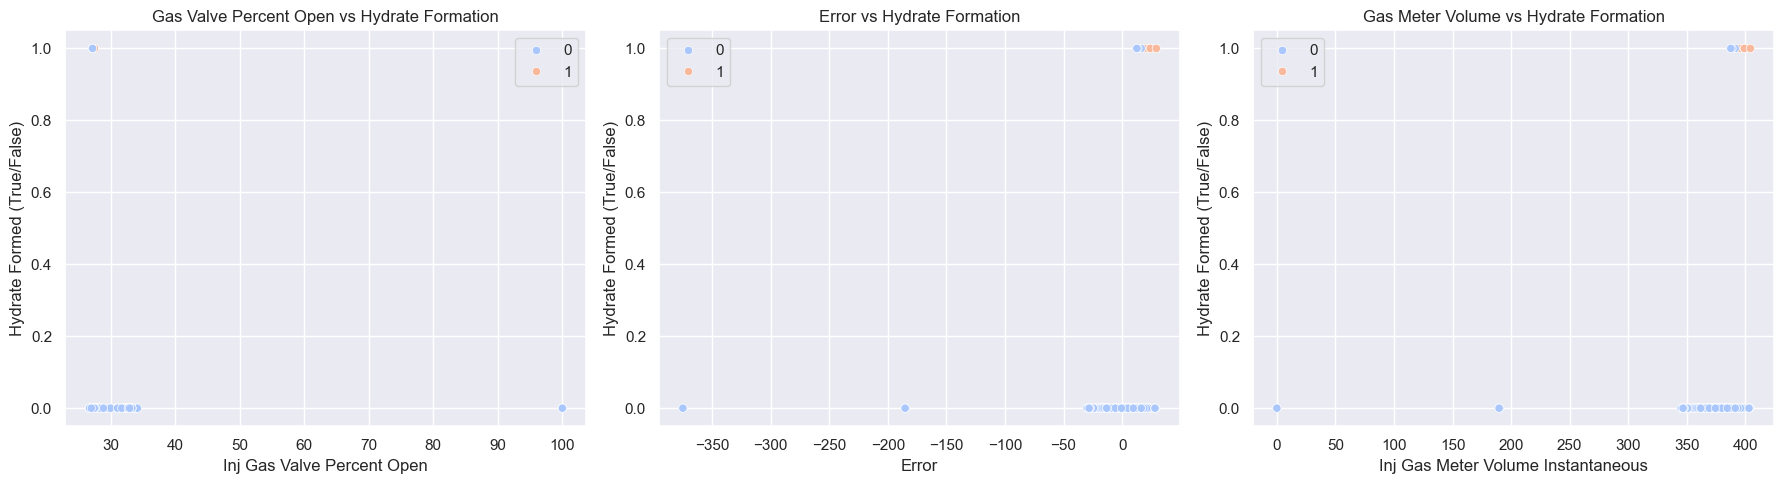

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))


# scatter plot for 'Inj Gas Valve Percent Open'
sns.scatterplot(data=X_test, x='Inj Gas Valve Percent Open', y=y_test, hue=y_pred, palette='coolwarm', ax=axes[0])
axes[0].set_title('Gas Valve Percent Open vs Hydrate Formation')
axes[0].set_xlabel('Inj Gas Valve Percent Open')
axes[0].set_ylabel('Hydrate Formed (True/False)')


# scatter plot for 'Error'
sns.scatterplot(data=X_test, x='Error', y=y_test, hue=y_pred, palette='coolwarm', ax=axes[1])
axes[1].set_title('Error vs Hydrate Formation')
axes[1].set_xlabel('Error')
axes[1].set_ylabel('Hydrate Formed (True/False)')


# scatter plot for 'Inj Gas Meter Volume Instantaneous'
sns.scatterplot(data=X_test, x='Inj Gas Meter Volume Instantaneous', y=y_test, hue=y_pred, palette='coolwarm', ax=axes[2])
axes[2].set_title('Gas Meter Volume vs Hydrate Formation')
axes[2].set_xlabel('Inj Gas Meter Volume Instantaneous')
axes[2].set_ylabel('Hydrate Formed (True/False)')

plt.tight_layout()
plt.show()
